# COVID-19 survival assignment
## Yoav Ram

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import pandas as pd
import emcee
from corner import corner
import seaborn as sns
sns.set_context('notebook')
sns.set_palette('muted')

import zipfile
import urllib.request
import os

red, blue, green = sns.color_palette('Set1', 3)

In this exercise we will attempt to model the number of days between COVID-19-related hospitalization and death, and infer the model parameters from data.

The data was recorded in Hubei province of China, and retrieved from [Xu & Kraemer, Lancet 2020](https://doi.org/10.1016/S1473-3099(20)30119-5).

The data was filtered to include data for patients that were admitted to hospitals in Hubei (mostly Wuhan) during Jan 2020 and that died in the hospital.

In [3]:
df = pd.read_csv('../data/covid-19_line_list_Hubei_9Feb.csv', index_col=0)
df

,date_admission_hospital,outcome,date_death_or_discharge
60,16.01.2020,died,20.01.2020
62,18.01.2020,died,19.01.2020
64,03.01.2020,died,15.01.2020
65,05.01.2020,died,18.01.2020
66,11.01.2020,died,20.01.2020
67,14.01.2020,died,21.01.2020
69,18.01.2020,died,22.01.2020
70,06.01.2020,died,22.01.2020
71,11.01.2020,died,21.01.2020
72,18.01.2020,died,22.01.2020


- **Convert the date columns to `datetime`**
- **Compute the array `X`** of the number of days in the hospital for each patient.
- **Plot a histogram of `X`**; make sure to add axes labels.

In [4]:
df['date_admission_hospital'] = pd.to_datetime(df['date_admission_hospital'], dayfirst=True)
df['date_death_or_discharge'] = pd.to_datetime(df['date_death_or_discharge'], dayfirst=True)
df['hospital_duration'] = df['date_death_or_discharge'] - df['date_admission_hospital']
df['hospital_duration'] = [x.days for x in df['hospital_duration']]
X = df['hospital_duration'].values

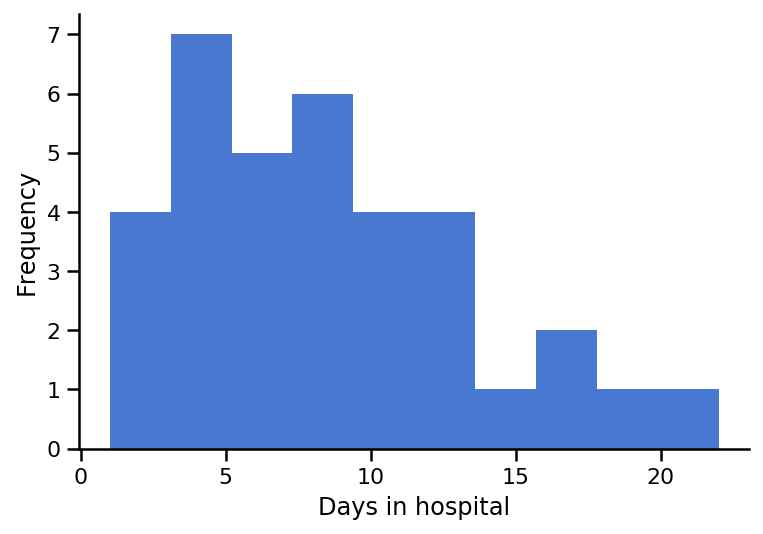

In [5]:
plt.hist(X, 10)
plt.xlabel('Days in hospital')
plt.ylabel('Frequency')
sns.despine()

A good model for the number of days before death is the [Weibull distribution](https://en.wikipedia.org/wiki/Weibull_distribution), which is commonly used to model time-to-failure. 
In Weibull, the failure rate, or the probability for failure per time unit, is proportional to a power of time. 

Weibull has two parameters:

- $\lambda$ is the basic failure rate
- $k$ is the power plus one; therefore, 
 - when $k<1$ the failure rate decreases with time; this occurs for example with infants (in general, not connected to COVID-19)
 - when $k=1$ the failure rate is constant in time; this corresponds to the exponential distribution and might occur if external factors unrelated to time are more important.
 - when $k>1$ the failure rate increases with time; this occurs for example if the available treatments are limited (as was the case in January), or if the hospital stay itself added risk.
 

The probability function of a Weibull distribution with parameters $\lambda$ and $k$ is

$$
P(x \mid \lambda, k) = \begin{cases}
\frac{k}{\lambda} \big(\frac{x}{\lambda}\Big)^{k-1} \exp\Big[{-\big(\frac{x}{\lambda}\big)^k}\Big], & x \ge 0, \\
0, & x < 0 
\end{cases}
$$

_Note 1_ that $k$ and $x$ look similar, so avoid making mistakes!

_Note 2_ This $P(x \mid \lambda, k)$ gives you the likelihood of $(\lambda, k)$ given $x$; this is not the log-likelihood! 

**Implement the log-likelihood function `log_likelihood(θ, X)`** for the Weibull distribution, $\log{P(X \mid \lambda, k)}$.

In [6]:
def log_likelihood(θ, X):
    λ, k = θ
    ll = np.log(k) + (k - 1) * np.log(X) - k * np.log(λ) - (X/λ)**k
    ll[X < 0] = -np.inf
    return ll.sum()

We now compute the log-likelihood for a range of $\lambda$ values and for the following $k$ values: $k=0.1$, $k=1$ (exponential distribution), $k=2$, and $k=4$.

We plot all the log-likelihoods we computed as a function of $\lambda$.

In [7]:
λ_range = np.linspace(X.min(), X.max()) 

# Exponential = Weibull k=1
ll_expon = [log_likelihood((λ_, 1), X) for λ_ in λ_range]

# Weibull
ll_weibull01 = [log_likelihood((λ_, 0.1), X) for λ_ in λ_range]
ll_weibull2 = [log_likelihood((λ_, 2), X) for λ_ in λ_range]
ll_weibull4 = [log_likelihood((λ_, 4), X) for λ_ in λ_range]

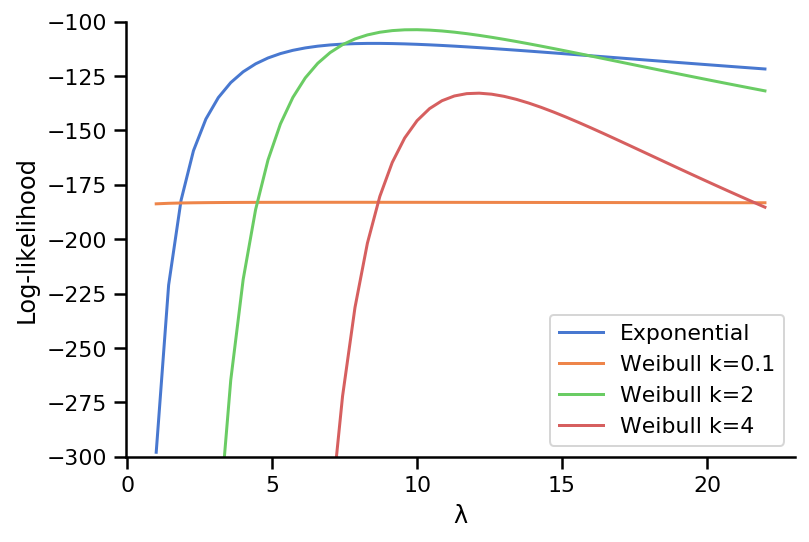

In [8]:
plt.plot(λ_range, ll_expon, label='Exponential')
plt.plot(λ_range, ll_weibull01, label='Weibull k=0.1')
plt.plot(λ_range, ll_weibull2, label='Weibull k=2')
plt.plot(λ_range, ll_weibull4, label='Weibull k=4')
plt.ylim(-300, -100)
plt.xlabel('λ')
plt.ylabel('Log-likelihood')
plt.legend()
sns.despine()

The above plot shows that the maximum likelihood estimate for $k$ is likely higher than 1 and lower than 4. 
Therefore, the exponential distribution ($k=1$) is likely inappropriate, and the **death rate likely increases every day in the hospital**.

Next, **compute the log-likelyhood for combinations of $\lambda$ and $k$ values**, and **find and print the MLE** (maximum likelihood estimate).

Then use the provided code to plot the log-likelihood plane and mark the MLE with green marker.

_Tip:_ when using `pcolormesh`, it is useful to manually set `vmin` and `vmax` to meaningful values; otherwise, extremely low log-likelihood will cause most of the plane to be of the same color. This is similar to manually setting `ylim` in the previous plot.

In [9]:
λ_range = np.linspace(X.min(), X.max(), 100) 
k_range = np.linspace(1, 4, 51) 

loglik = np.array([
    [log_likelihood((λ_, k_), X) for λ_ in λ_range] 
    for k_ in k_range
])

In [10]:
k_idx, λ_idx = (loglik == loglik.max()).nonzero()
λ_hat = λ_range[λ_idx][0]
k_hat = k_range[k_idx][0]
print('λ_hat = {:.2f}, k_hat={:.2f}'.format(λ_hat, k_hat)) 

λ_hat = 9.48, k_hat=1.72


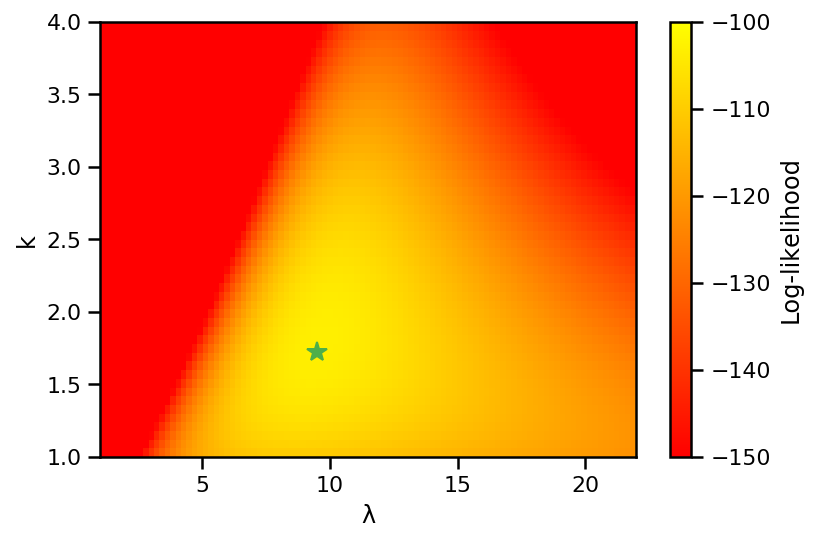

In [11]:
plt.pcolormesh(λ_range, k_range, loglik, cmap='autumn', vmin=-150, vmax=-100, rasterized=True)
plt.plot(λ_hat, k_hat, '*', markersize=10, color=green)
plt.xlabel('λ')
plt.ylabel('k')
plt.colorbar(label='Log-likelihood');

Now, we will estimate the joint posterior of $\lambda$ and $k$ using _emcee_.

- **Define `log_prior` and `log_posterior`**.
- **Make guesses of $\lambda$ and $k$ for each emcee walker** using the log-likelihood plots from above.
- **Run the emcee sampler to get samples from the posterior**.

Note: you can define the prior as a uniform in some range, consult with the log-likelihood plot above for an appropriate range.

In [12]:
def log_prior(θ): 
    λ, k = θ
    if 5 < λ < 15 and 1 < k < 4:
        return 0
    else:
        return -np.inf
    
def log_posterior(θ, X): 
    pri = log_prior(θ)
    if pri < 0:
        return pri
    return pri + log_likelihood(θ, X)

In [13]:
ndim, nwalkers = 2, 50 
nsteps, nburn = 1000, 500 

guesses = np.empty((nwalkers, ndim), dtype=float)
guesses[:, 0] = np.random.uniform(5, 15, size=nwalkers)
guesses[:, 1] = np.random.uniform(1, 4, size=nwalkers)

In [14]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[X])
sampler.run_mcmc(guesses, nsteps)

# sampler.chain.shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, 2)

**Get the $\lambda$ and $k$ samples** from the sampler in arrays called `λ_sample` and `k_sample`,

Then **Compute the MAP** (maximum a posterior estimate) of $\lambda$ and $k$ and set them to `λ_hat_mcmc` and `k_hat_mcmc`.
Then print them together with the MLE for comparison.



In [15]:
λ_sample = sample[:,0] 
k_sample = sample[:,1] 
λ_hat_mcmc = λ_sample.mean()
k_hat_mcmc = k_sample.mean()

print('MLE:  λ_hat = {:.2f}, k_hat={:.2f}'.format(λ_hat, k_hat)) ### 
print('MCMC: λ_hat = {:.2f}, k_hat={:.2f}'.format(λ_hat_mcmc, k_hat_mcmc)) ###

MLE:  λ_hat = 9.48, k_hat=1.72
MCMC: λ_hat = 9.70, k_hat=1.73


We plot a trace plot of both $\lambda$ and $k$.

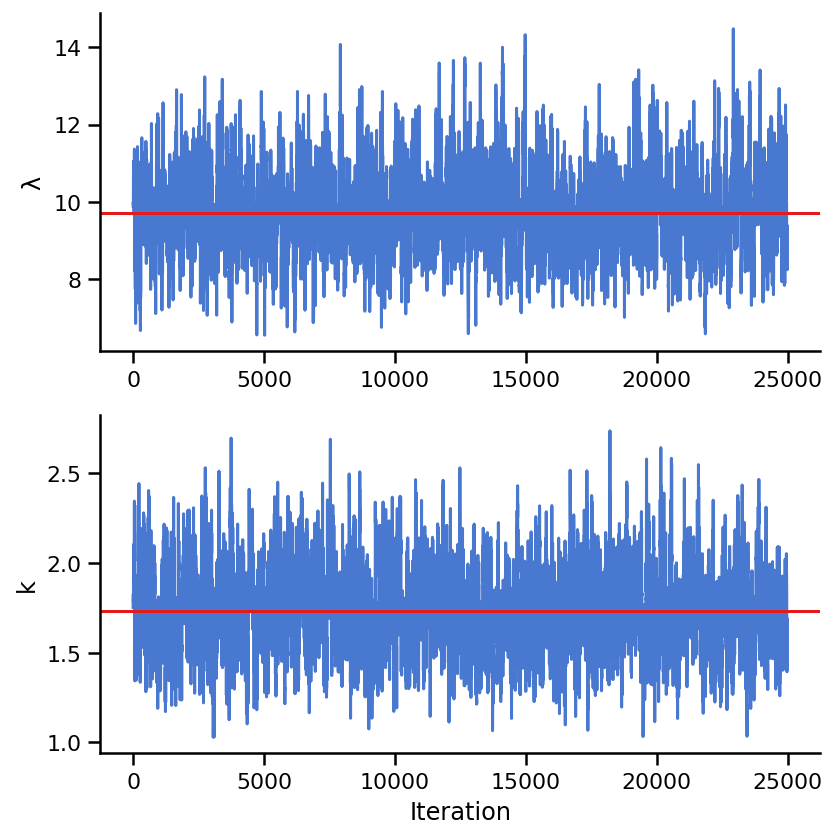

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6))
axes[0].plot(λ_sample)
axes[0].axhline(λ_hat_mcmc, color=red)
axes[1].plot(k_sample)
axes[1].axhline(k_hat_mcmc, color=red)
axes[0].set(ylabel='λ')
axes[1].set(xlabel='Iteration', ylabel='k')
fig.tight_layout()
sns.despine()

**Plot the marginal and joint posterior distribution**.
Add lines and markers to show the MAP (red) and MLE (green).

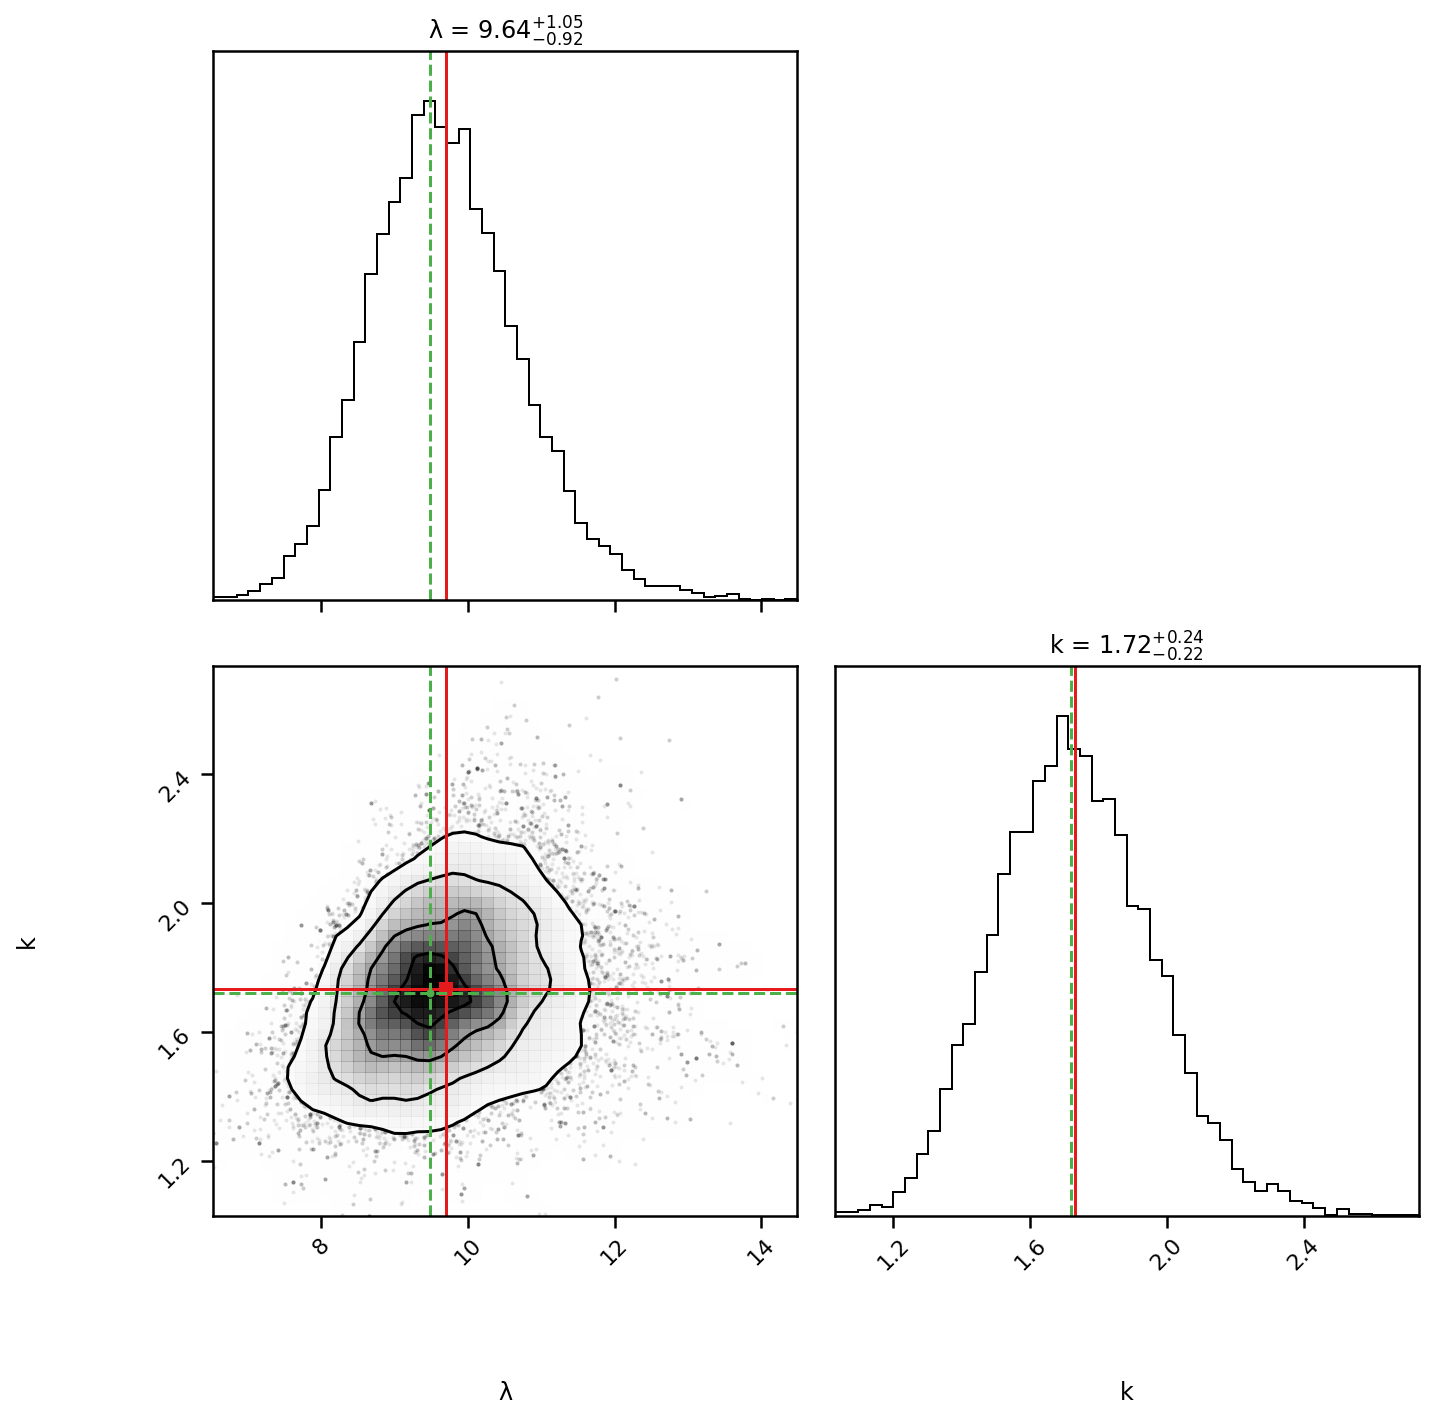

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
cor = corner(sample, 
    bins=50, smooth=True, 
    labels=['λ', 'k'],
    truths=[λ_hat_mcmc, k_hat_mcmc],
    truth_color=red,
    show_titles=True,
    fig=fig,               
)
cor.axes[0].axvline(λ_hat, ls='--', color=green)
cor.axes[3].axvline(k_hat, ls='--', color=green)
cor.axes[2].axvline(λ_hat, ls='--', color=green)
cor.axes[2].axhline(k_hat, ls='--', color=green)
cor.axes[2].plot(λ_hat, k_hat, '.', color=green)
fig.tight_layout()

Now, we plot the survival function that gives the probability of survival after $x$ days (for a hospitalized patient that will eventually die in the hospital, so this is conditioned on death, like all our analysis).

The survival function is the complement of the cumulative distribution function. It can be written as:
$$
s(x) = \exp\Big[{-\big(\frac{x}{\lambda}\big)^k}\Big],
$$
where $x$ is the number of days since hospitalization and $s(x)$ is the probability to survive $x$ days.

In addition, we print the median number of days before death conditioned on eventual death.

Median survival days: 7.85


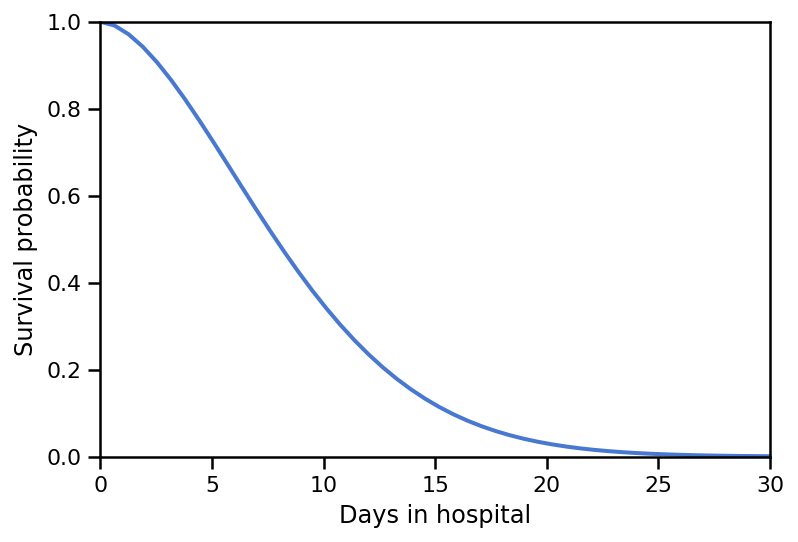

In [18]:
def survival_probability(θ, x):
    λ, k = θ
    return np.exp(-(x/λ)**k)

x_range = np.linspace(0, 31)
plt.plot(x_range, survival_probability((λ_hat_mcmc, k_hat_mcmc), x_range), lw=2)
plt.xlim(0, 30)
plt.ylim(0, 1)
plt.ylabel('Survival probability')
plt.xlabel('Days in hospital')

median = λ_hat_mcmc * np.log(2)**(1/k_hat_mcmc)
print("Median survival days: {:.2f}".format(median)) ###